---
title: Converting NetCDF to COG (CMIP6)
author: Jonas Sølvsteen
date: 'June 20, 2023'
execute:
  cache: true
  freeze: true
---

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://binder.openveda.cloud/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=notebooks%2Ftutorials%2Fnetcdf-to-cog-cmip6.ipynb">
<img src="https://binder.openveda.cloud/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>


## Approach

[Cloud-optimized GeoTIFF (COG)](https://www.cogeo.org/) is a geospatial raster (image) data format optimized for on-the-fly analytics and visualization of raster data in cloud applications.

Converting [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) (climate data) to COG can be relevant when the data should be included in GIS or web map applications.

This tutorial shows how this conversion can be done using [Xarray](https://github.com/pydata/xarray) and [rioxarray](https://github.com/corteva/rioxarray), in-memory, avoiding temporary files on-disk.

1. Step-by-step guide to conversion from NetCDF to Cloud-Optimized GeoTIFF
2. Combined workflow including upload to S3

## Step by step

### Step 0 - Installs

In [1]:
import boto3
import rio_cogeo.cogeo
import rioxarray  # noqa
import s3fs
import xarray as xr
from rasterio.io import MemoryFile

### Step 1 - Inspect source NetCDF

In [2]:
SOURCE_URI = (
    "cmip6-staging/Sample/FWI/Yearly/MME/MME50_historical_fwi_metrics_yearly_2014.nc"
)

In [3]:
fs = s3fs.S3FileSystem()
fileobj = fs.open(SOURCE_URI)
ds = xr.open_dataset(fileobj, engine="h5netcdf")
ds

<xarray.Dataset> Size: 40MB
Dimensions:  (lat: 600, lon: 1440)
Coordinates:
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables: (12/13)
    FFMC     (lat, lon) float32 3MB ...
    DMC      (lat, lon) float32 3MB ...
    DC       (lat, lon) float32 3MB ...
    ISI      (lat, lon) float32 3MB ...
    BUI      (lat, lon) float32 3MB ...
    FWI      (lat, lon) float32 3MB ...
    ...       ...
    FWI_N30  (lat, lon) uint16 2MB ...
    FWI_N45  (lat, lon) uint16 2MB ...
    FWI_P25  (lat, lon) float32 3MB ...
    FWI_P50  (lat, lon) float32 3MB ...
    FWI_P75  (lat, lon) float32 3MB ...
    FWI_P95  (lat, lon) float32 3MB ...

### Step 2 - Select data variable

The NetCDF contains several data variables. We pick the first one for demo.

In [4]:
VARIABLE_NAME = "FFMC"

In [5]:
da = ds[VARIABLE_NAME]

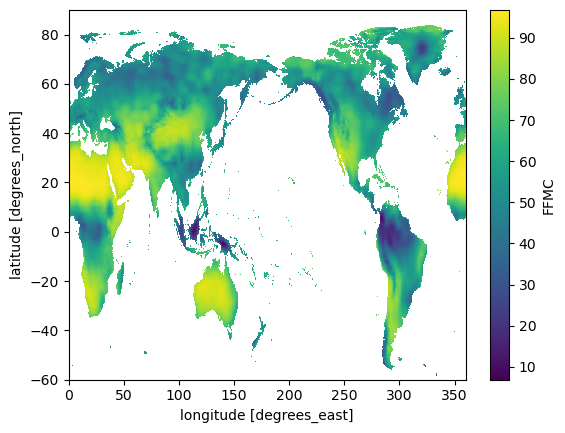

In [6]:
da.plot();

In [7]:
da.encoding

{'chunksizes': None,
 'fletcher32': False,
 'shuffle': False,
 'source': '<File-like object S3FileSystem, cmip6-staging/Sample/FWI/Yearly/MME/MME50_historical_fwi_metrics_yearly_2014.nc>',
 'original_shape': (600, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': np.float32(nan)}

### Step 3. Conform to raster data conventions

Common practice in NetCDF lat/lon data the first grid cell is the south-west corner, i.e. latitude and longitude axes increase along the array dimensions.

Common practice in raster formats like GeoTIFF is that the y-axis (latitude in this case) decreases from origin, i.e. the first pixel is the north-west corner.

We can reverse the latitude dimension like this:

In [8]:
da = da.isel(lat=slice(None, None, -1))
da.lat

<xarray.DataArray 'lat' (lat: 600)> Size: 5kB
array([ 89.875,  89.625,  89.375, ..., -59.375, -59.625, -59.875], shape=(600,))
Coordinates:
  * lat      (lat) float64 5kB 89.88 89.62 89.38 89.12 ... -59.38 -59.62 -59.88
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude
    axis:           Y

We would also like the longitude axis to range from -180 to 180 degrees east, instead of 0 to 360 degrees east (matter of taste, not convention).

In [9]:
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby("lon")
da.lon

<xarray.DataArray 'lon' (lon: 1440)> Size: 12kB
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      shape=(1440,))
Coordinates:
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

Check that the data still looks right, just rotated along x-axis:

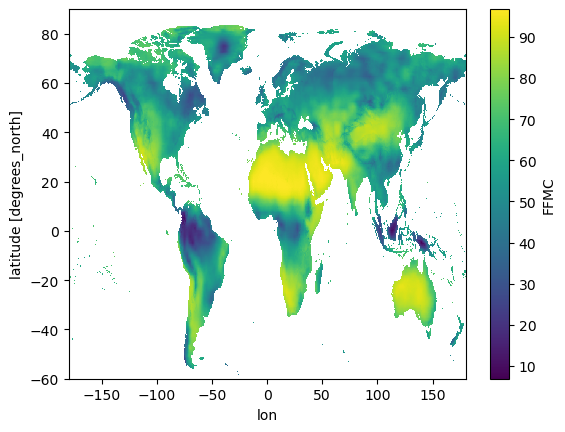

In [10]:
da.plot();

Now we need to set raster data attributes which are missing from the NetCDF, to help rio-xarray infer the raster information

In [11]:
da.rio.set_spatial_dims("lon", "lat", inplace=True)
da.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'FFMC' (lat: 600, lon: 1440)> Size: 3MB
[864000 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 5kB 89.88 89.62 89.38 ... -59.38 -59.62 -59.88
  * lon          (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    spatial_ref  int64 8B 0

Check CRS

In [12]:
da.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

Check [affine image transform](https://www.perrygeo.com/python-affine-transforms.html):

    a = width of a pixel
    b = row rotation (typically zero)
    c = x-coordinate of the upper-left corner of the upper-left pixel
    d = column rotation (typically zero)
    e = height of a pixel (typically negative)
    f = y-coordinate of the of the upper-left corner of the upper-left pixel


In [13]:
da.rio.transform()

Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 90.0)

### Step 4 - Write to COG and validate in-memory

For the demonstration here, we do not write the file to disk but to a memory file which can be validated and uploaded in-memory

GeoTIFFs / COGs can be tuned for performance. Here are some defaults we found to work well (check out [this blog post](https://kokoalberti.com/articles/geotiff-compression-optimization-guide) for detail).

In [14]:
COG_PROFILE = {"driver": "COG", "compress": "DEFLATE", "predictor": 2}

In [15]:
with MemoryFile() as memfile:
    da.rio.to_raster(memfile.name, **COG_PROFILE)

    cog_valid = rio_cogeo.cogeo.cog_validate(memfile.name)[0]

cog_valid

True

## Combined workflow from conversion to upload

In [16]:
SOURCE_URI = (
    "cmip6-staging/Sample/FWI/Yearly/MME/MME50_historical_fwi_metrics_yearly_2014.nc"
)

In [17]:
VARIABLE_NAME = "FFMC"

In [18]:
COG_PROFILE = {"driver": "COG", "compress": "DEFLATE", "predictor": 2}

In [19]:
DESTINATION_BUCKET = None
DESTINATION_KEY = None

In [20]:
fs = s3fs.S3FileSystem()
with fs.open(SOURCE_URI) as fileobj:
    with xr.open_dataset(fileobj, engine="h5netcdf") as ds:

        # Read individual metric into data array (only one time in yearly NetCDFs)
        da = ds[VARIABLE_NAME]

        # Realign the x dimension to -180 origin for dataset
        da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby("lon")

        # Reverse the DataArray's y dimension to comply with raster common practice
        if da.lat.values[-1] > da.lat.values[0]:
            da = da.isel(lat=slice(None, None, -1))

        # Set raster attributes
        da.rio.set_spatial_dims("lon", "lat")
        da.rio.write_crs("epsg:4326", inplace=True)

        with MemoryFile() as memfile:
            da.rio.to_raster(memfile.name, **COG_PROFILE)

            # Validate COG in-memory
            cog_valid = rio_cogeo.cogeo.cog_validate(memfile.name)[0]
            if not cog_valid:
                raise RuntimeError("COG validation failed.")

            # Upload to S3
            if DESTINATION_BUCKET is not None:
                client = boto3.client("s3")
                r = client.put_object(
                    Body=memfile,
                    Bucket=DESTINATION_BUCKET,
                    Key=DESTINATION_KEY,
                )
                if r["ResponseMetadata"]["HTTPStatusCode"] != 200:
                    raise RuntimeError("Upload failed.")